In [6]:
# Load dependences
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import urllib
import folium
import gpxpy
import sys
import os
from shapely.geometry import Point, Polygon

%matplotlib inline

In [7]:
# Path
path = os.path.dirname('__file__')

In [8]:
# Read data
def read_gpx(file: str) -> pd.DataFrame:
    df = None
    points = []
    with open(file) as f:
        gpx = gpxpy.parse(f)
    for segment in gpx.tracks[0].segments:
        for p in segment.points:
            points.append({
                'time': p.time,
                'latitude': p.latitude,
                'Longitude': p. longitude,
                'elevation': p.elevation
            })
    df = pd.DataFrame.from_records(points)
    return df

# Calculate elevation
API_KEY = 'ak_fHS5JRMf_JWxpY385oWW5gMow'  # Get a free key from www.gpxz.io.
BATCH_SIZE = 50  # 512 for paid customers.

def gpxz_elevation(lats, lons):
    '''Iterate over the coordinates in chunks, querying the GPXZ api to return
    a list of elevations in the same order.'''
    elevations = []
    n_chunks = int(len(lats) // BATCH_SIZE) + 1
    lat_chunks = np.array_split(lats, n_chunks) 
    lon_chunks = np.array_split(lons, n_chunks)
    for lat_chunk, lon_chunk in zip(lat_chunks, lon_chunks):
        latlons = '|'.join(f'{lat},{lon}' for lat, lon in zip(lat_chunk, lon_chunk))
        response = requests.post(
            'https://api.gpxz.io/v1/elevation/points', 
            headers={'x-api-key': API_KEY},
            data={'latlons': latlons},
        )
        response.raise_for_status()
        elevations += [r['elevation'] for r in response.json()['results']]
    return elevations


def add_elevation_to_gpx(gpx_path, output_path='with_elevation.gpx'):
    # Load gpx.
    gpx_path = 'run.gpx'
    with open(gpx_path) as f:
        gpx = gpxpy.parse(f)

    # Find points.
    points = list(gpx.walk(only_points=True))
    latitudes = [p.latitude for p in points]
    longitudes = [p.longitude for p in points]

    # Update elevations.
    elevations = gpxz_elevation(latitudes, longitudes)
    for point, elevation in zip(points, elevations):
        point.elevation = elevation

    # Save gpx file.
    with open(output_path, 'w') as f:
        f.write(gpx.to_xml())     

In [9]:
# Read as dataframes
data_path_dic = {
    'recovery_01': os.path.join(path, './data_raw/recovery.01-Mar-2022-1533.gpx'),
    'recovery_05': os.path.join(path, './data_raw/recovery.05-Mar-2022.1025.gpx'),
    'recovery_25': os.path.join(path, './data_raw/recovery.25-May-2022-0907.gpx'),
    'cocorollo': os.path.join(path, './data_created/cocorollo.gpx'),
    'euro': os.path.join(path, './data_created/euro.gpx'),
    'frisby': os.path.join(path, './data_created/frisby.gpx'),
    'parques': os.path.join(path, './data_created/parques.gpx')
}

df_01 = read_gpx(data_path_dic["recovery_01"])
df_05 = read_gpx(data_path_dic["recovery_05"])
df_25 = read_gpx(data_path_dic["recovery_25"])
df_cocorollo = read_gpx(data_path_dic["cocorollo"])
df_euro = read_gpx(data_path_dic["euro"])
df_frisby = read_gpx(data_path_dic["frisby"])
df_parques = read_gpx(data_path_dic["parques"])

In [10]:
#add_elevation_to_gpx("./data_created/cocorollo.gpx", output_path='./data_created/prueba.gpx')

In [11]:
#df_cocorollo = get_altitude(df_cocorollo, df_cocorollo['latitude'], df_cocorollo['Longitude'])

In [12]:
#df_cocorollo.info()

In [13]:
df_01.head()

,time,latitude,Longitude,elevation
0,2022-03-01 20:33:48+00:00,6.297476,-75.578192,1668.879307
1,2022-03-01 20:33:49+00:00,6.297476,-75.578146,1668.386143
2,2022-03-01 20:33:57+00:00,6.297460,-75.578169,1667.904453


In [14]:
df_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype                        
---  ------     --------------  -----                        
 0   time       3 non-null      datetime64[ns, SimpleTZ("Z")]
 1   latitude   3 non-null      float64                      
 2   Longitude  3 non-null      float64                      
 3   elevation  3 non-null      float64                      
dtypes: datetime64[ns, SimpleTZ("Z")](1), float64(3)
memory usage: 224.0 bytes


In [15]:
df_05.head()

,time,latitude,Longitude,elevation
0,2022-03-04 00:04:34+00:00,6.180893,-75.577296,1589.639492
1,2022-03-04 00:04:35+00:00,6.180912,-75.577295,1588.165859
2,2022-03-04 00:04:43+00:00,6.180921,-75.577312,1591.435879
3,2022-03-04 00:04:46+00:00,6.180897,-75.577270,1587.116055
4,2022-03-04 00:04:48+00:00,6.180874,-75.577276,1586.772305


In [16]:
df_05.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18593 entries, 0 to 18592
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype                        
---  ------     --------------  -----                        
 0   time       18593 non-null  datetime64[ns, SimpleTZ("Z")]
 1   latitude   18593 non-null  float64                      
 2   Longitude  18593 non-null  float64                      
 3   elevation  18593 non-null  float64                      
dtypes: datetime64[ns, SimpleTZ("Z")](1), float64(3)
memory usage: 581.2 KB


In [17]:
df_05[df_05.duplicated(['latitude'])]

,time,latitude,Longitude,elevation
38,2022-03-04 00:21:03+00:00,6.180957,-75.577246,1606.784512
42,2022-03-04 00:21:15+00:00,6.180921,-75.577201,1606.262051
62,2022-03-04 00:22:21+00:00,6.180770,-75.577141,1601.305996
157,2022-03-04 00:32:01+00:00,6.180868,-75.577183,1589.329678
257,2022-03-04 00:38:12+00:00,6.180882,-75.577014,1566.878750
...,...,...,...,...
17858,2022-03-05 14:19:17+00:00,6.265207,-75.591524,1502.883579
18129,2022-03-05 14:31:57+00:00,6.260172,-75.588852,1485.919712
18353,2022-03-05 14:40:30+00:00,6.254302,-75.590716,1478.987217
18419,2022-03-05 14:44:51+00:00,6.255013,-75.591135,1478.726109


In [18]:
df_25.head()

,time,latitude,Longitude,elevation
0,2022-05-25 21:24:46.433000+00:00,6.208559,-75.571630,1558.78
1,2022-05-26 14:05:32.284000+00:00,6.268901,-75.593216,1548.51
2,2022-05-26 14:05:34+00:00,6.268870,-75.593087,1551.91
3,2022-05-26 14:05:36+00:00,6.268792,-75.593007,1551.53
4,2022-05-26 14:05:37+00:00,6.268722,-75.592900,1551.37


In [19]:
df_25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype                        
---  ------     --------------  -----                        
 0   time       658 non-null    datetime64[ns, SimpleTZ("Z")]
 1   latitude   658 non-null    float64                      
 2   Longitude  658 non-null    float64                      
 3   elevation  658 non-null    float64                      
dtypes: datetime64[ns, SimpleTZ("Z")](1), float64(3)
memory usage: 20.7 KB


In [20]:
# # initialize the map and store it in a m object
# m = folium.Map(location=[40, -95], zoom_start=20)

# # show the map
# m

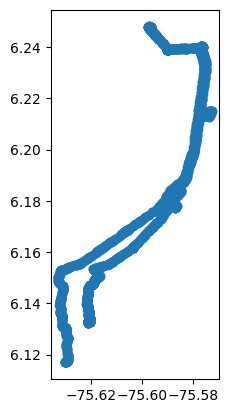

In [21]:
#Creating a geodataframe
data = df_cocorollo
points = gpd.points_from_xy(data["Longitude"], data["latitude"])
map = gpd.GeoDataFrame (data, geometry=points) 
map.plot()

plt.show()

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd

data = df_01

fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h',
            lat_0=data['latitude'].mean(), lon_0=data['Longitude'].mean(),
            width=1e6, height=1.2e6)

m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.fillcontinents(color='lightgray', lake_color='white')
m.drawmapboundary(fill_color='white')

x, y = m(data['Longitude'].values, data['latitude'].values)
m.scatter(x, y, s=data['elevation'].values, c='red', alpha=0.5, marker='.', linewidth=0.5)

plt.show()

OSError: Unable to open boundary dataset file. Only the 'crude', 'low' and
'intermediate' resolution datasets are installed by default. If you
are requesting a 'high' or 'full' resolution dataset, you need to
install the `basemap-data-hires` package.

<Figure size 800x800 with 0 Axes>

In [ ]:
data = df_05

print('elevation',data['elevation'].min(),data['elevation'].max())
print('latitude',data['latitude'].min(),data['latitude'].max())
print('longitude',data['Longitude'].min(),data['Longitude'].max())